# Forest Fire Classification model 

### This notebook makes the use of the `Active Fire Data` for India in the year 2021 provided by `NASA`.
- You can find several other datasets provided by  [here](https://www.earthdata.nasa.gov/)

### Let's first analyse the dataset

In [71]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

In [92]:
data_17 = pd.read_csv("../data/modis_2017_India.csv")
data_18 = pd.read_csv("../data/modis_2018_India.csv")
data_19 = pd.read_csv("../data/modis_2019_India.csv")
data_20 = pd.read_csv("../data/modis_2020_India.csv")
data_21 = pd.read_csv("../data/modis_2021_India.csv")
data_22 = pd.read_csv("../data/modis_2022_India.csv")

In [93]:
# Merge all dataframes into one dataframe
df = pd.concat([data_17,data_18,data_19,data_20,data_21,data_22])

### The columns represent the following: 
- `latitude`: Latitude of the fire pixel detected by the satellite *(degrees)*
- `longitude`: Longitude of the fire pixel detected by the satellite *(degrees)*
- `brightness`: Brightness temperature of the fire pixel *(in K)*
- `scan`: Area of a MODIS pixel at the Earth’s surface *(Along-scan: ΔS)*
- `track`: Area of a MODIS pixel at the Earth’s surface *(Along-track: ΔT)*
- `acq_time`: Time at which the fire was detected
- `satellite`: Satellite used to detect the fire. Either Terra(T) or Aqua(A)
- `instrument`: MODIS
- `confidence`: Detection confidence *(range 0-100)*
- `bright_t31`:  Band 31 brightness temperature of the pixel *(in K)*
- `frp`: Fire radiative power *(in MW- megawatts)*
- `daynight`: Detected during the day or night. Either Day(D) or Night(N) 
- `type`: Inferred hot spot type: 
         - 0= presumed vegetation fire 
         - 1= active volcano
         - 2= other static land source
         - 3= offshore

### In this notebook, we will be building models to predict the type of forest fire detected by MODIS.

In [106]:
df.columns

Index(['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date',
       'acq_time', 'satellite', 'instrument', 'confidence', 'version',
       'bright_t31', 'frp', 'daynight', 'type'],
      dtype='object')

In [108]:
print(df['satellite'].value_counts())
print(df['daynight'].value_counts())
print(df['type'].value_counts())

satellite
Aqua     355660
Terra    161917
Name: count, dtype: int64
daynight
D    460469
N     57108
Name: count, dtype: int64
type
0    490747
2     26830
Name: count, dtype: int64


> We can see that: 
- There is a huge imbalance of classes in the `type` column for number `3`. Hence we can drop it.

In [107]:
df = df.query('type != 1 and type != 3')
df.reset_index(drop=True, inplace=True)

### Handling categorical values
- Since we have 2 values (Terra and Aqua) for satellite, we will be using a binary encoder

In [109]:
df.shape

(517577, 15)

In [110]:
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['satellite'])
df = encoder.fit_transform(df)
encoder = ce.BinaryEncoder(cols=['daynight'])
df = encoder.fit_transform(df)

In [111]:
df.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite_0,satellite_1,instrument,confidence,version,bright_t31,frp,daynight_0,daynight_1,type
0,31.4814,75.7365,301.5,1.4,1.2,2017-01-01,529,0,1,MODIS,48,6.2,291.1,5.4,0,1,0
1,28.7628,79.5194,311.3,1.0,1.0,2017-01-01,530,0,1,MODIS,71,6.2,292.8,8.6,0,1,0
2,28.0761,79.8547,304.2,1.0,1.0,2017-01-01,530,0,1,MODIS,58,6.2,290.6,5.0,0,1,0
3,28.5888,78.7448,305.0,1.0,1.0,2017-01-01,530,0,1,MODIS,60,6.2,293.5,4.3,0,1,0
4,29.4661,77.1339,303.3,1.1,1.1,2017-01-01,530,0,1,MODIS,56,6.2,291.6,5.6,0,1,0


- Here `satellite_0` is for Aqua while `satellite_1` is for Terra
- And `daynight_0` is for Day while `daynight_1` is for Night
- Hence we can remove one of them

In [112]:
df=df.drop(['satellite_1','daynight_1'], axis=1)
df['acq_date'] = pd.to_datetime(df['acq_date'])
df['acq_date'] = df['acq_date'].apply(lambda x: x.timestamp())

### Handling the time column `acq_time`
- Since it's in the format HHMM, we will only extract the hours part of the time, minutes won't be relevant for our model. 
- using floor division we removed last 2 digits that represented the minutes

In [113]:
df['acq_time'] = df['acq_time']//100 
df.head()
    

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite_0,instrument,confidence,version,bright_t31,frp,daynight_0,type
0,31.4814,75.7365,301.5,1.4,1.2,1.483229e+09,5,0,MODIS,48,6.2,291.1,5.4,0,0
1,28.7628,79.5194,311.3,1.0,1.0,1.483229e+09,5,0,MODIS,71,6.2,292.8,8.6,0,0
2,28.0761,79.8547,304.2,1.0,1.0,1.483229e+09,5,0,MODIS,58,6.2,290.6,5.0,0,0
3,28.5888,78.7448,305.0,1.0,1.0,1.483229e+09,5,0,MODIS,60,6.2,293.5,4.3,0,0
4,29.4661,77.1339,303.3,1.1,1.1,1.483229e+09,5,0,MODIS,56,6.2,291.6,5.6,0,0


### Feature Selection and finding the correlation

- We are using `stratified shuffle split` since our dataset contains unbalanced classes for the `type` column. 

In [115]:
df.drop(["index","instrument"],axis=1,inplace=True)

In [81]:
feature_cols =  [x for x in df.columns if x not in ['type','acq_date']]
feature_cols

['latitude',
 'longitude',
 'brightness',
 'scan',
 'track',
 'acq_time',
 'satellite_0',
 'confidence',
 'version',
 'bright_t31',
 'frp',
 'daynight_0']

In [116]:
from sklearn.model_selection import StratifiedShuffleSplit
target=['type']

feature_cols = [x for x in df.columns if x not in target]

strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(df[feature_cols], df[target]))

# Create the data sets
X_train = df.loc[train_idx, feature_cols]
y_train = df.loc[train_idx, target]
X_test = df.loc[test_idx, feature_cols]
y_test = df.loc[test_idx, target]

- Now that we have split the model, we will start with the feature selection

<Axes: >

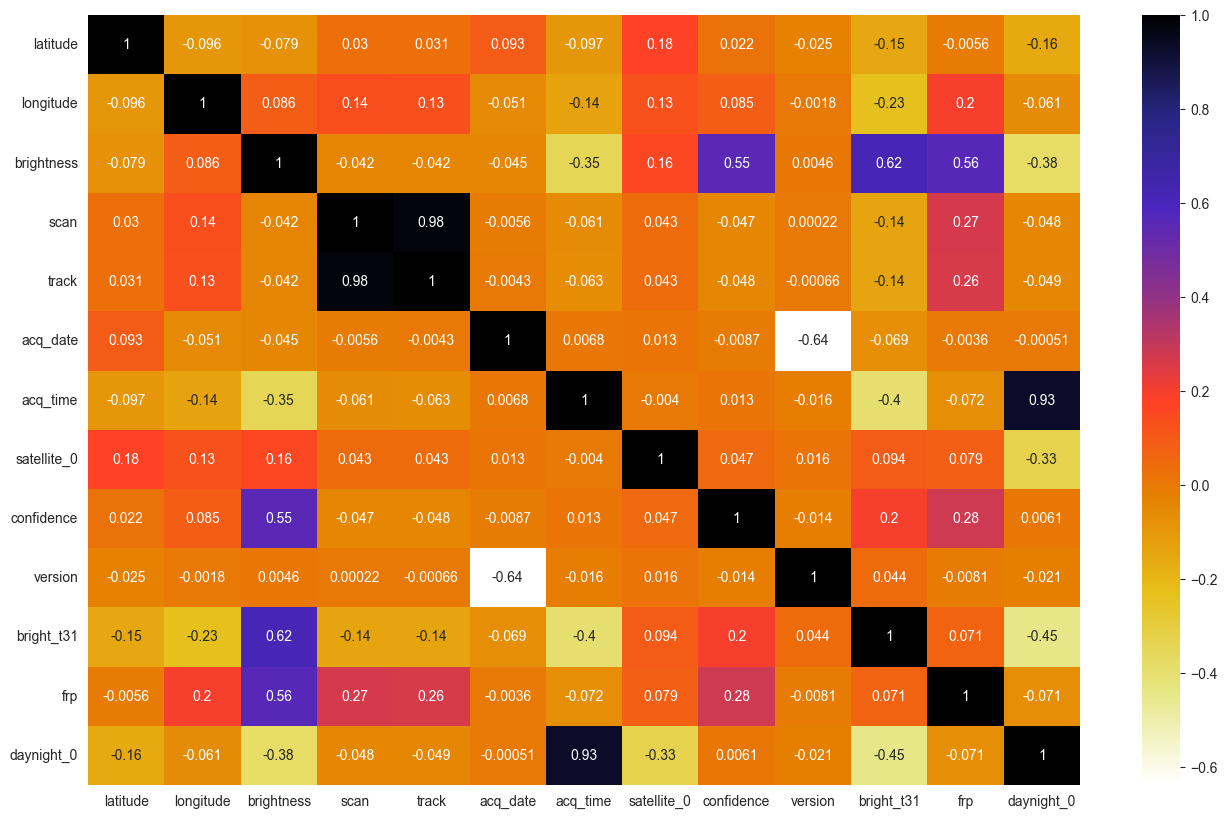

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
cor=X_train.corr(numeric_only=True)
sns.heatmap(cor,annot=True,cmap=plt.cm.CMRmap_r)

> We will define a function to identify the highly correlated features to remove them

In [118]:
df

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite_0,confidence,version,bright_t31,frp,daynight_0,type
0,31.4814,75.7365,301.5,1.4,1.2,1.483229e+09,5,0,48,6.20,291.1,5.4,0,0
1,28.7628,79.5194,311.3,1.0,1.0,1.483229e+09,5,0,71,6.20,292.8,8.6,0,0
2,28.0761,79.8547,304.2,1.0,1.0,1.483229e+09,5,0,58,6.20,290.6,5.0,0,0
3,28.5888,78.7448,305.0,1.0,1.0,1.483229e+09,5,0,60,6.20,293.5,4.3,0,0
4,29.4661,77.1339,303.3,1.1,1.1,1.483229e+09,5,0,56,6.20,291.6,5.6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517572,29.9033,74.9521,303.3,2.7,1.6,1.672445e+09,17,0,55,6.03,281.3,37.2,1,0
517573,29.9086,74.9460,323.9,2.7,1.6,1.672445e+09,17,0,100,6.03,282.0,106.5,1,0
517574,29.9170,74.9576,323.5,1.9,1.3,1.672445e+09,21,1,100,6.03,274.6,66.9,1,0
517575,21.1048,72.6415,302.9,2.0,1.4,1.672445e+09,21,1,52,6.03,289.9,18.5,1,2


In [119]:
def correlation(dataset, threshold):
     col_corr = set() # Set of all the names of correlated columns
     corr_matrix = dataset.corr(numeric_only=True)
     for i in range(len(corr_matrix.columns)):
         for j in range(i):
             if (corr_matrix.iloc[i,j])>threshold: # we are interested in absolute coeff value
                 colname= corr_matrix.columns[i] # getting the name of column
                 col_corr.add(colname) 
     return col_corr


In [120]:
features= correlation(X_train,0.9)
print(set(features))

{'track', 'daynight_0'}


> We can now drop the features `track` and `daynight_0` 

In [121]:
X_train=X_train.drop(['track','daynight_0'],axis=1)

### Applying the same to test data

In [124]:
X_test=X_test.drop(['track','daynight_0'],axis=1)

## Applying Machine Learning Models
- We will be applying 3 models and comparing it with each other: 
 - Logistic Regression 
 - K Nearest Neighbours 
 - XG Boost

### Logistic Regression

We are keeping an `l2 regularization` since it has comparatively lesser computational complexity 

In [89]:
X_train.columns.to_list()

['latitude',
 'longitude',
 'brightness',
 'scan',
 'acq_date',
 'acq_time',
 'satellite_0',
 'confidence',
 'version',
 'bright_t31',
 'frp']

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearnex import patch_sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

patch_sklearn(global_patch=True)

# Define the hyperparameters
param_grid = [
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],"n_jobs":[-1]},
    {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],"n_jobs":[-1]}
]
# Initialize a Logistic Regression classifier
logreg = LogisticRegression(max_iter=100000)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = grid_search.best_params_

# Fit the model with the best parameters
logreg_best = LogisticRegression(**best_parameters)
logreg_best.fit(X_train, y_train)

# Predict the test set results
y_pred = logreg_best.predict(X_test)

# Print the results
print("Best parameters for Logistic Regression: ", best_parameters)
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/Users/kausik/.local/share/virtualenvs/Forest_Fire_Prediction-Mr6mG4gB/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kausik/.local/share/virtualenvs/Forest_Fire_Prediction-Mr6mG4gB/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kausik/.local/share/virtualenvs/Forest_Fire_Prediction-Mr6mG4gB/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.war

In [ ]:
import pickle
    
# Save the model
pickle.dump(logreg,open("best_logreg.pkl","wb"))

In [16]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear', penalty='l2').fit(X_train, y_train)

> Plotting the confusion matrix 

In [17]:
predictions=lr.predict(X_test)

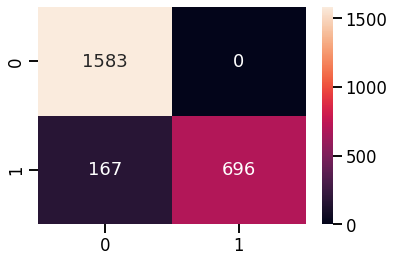

In [18]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
sns.set_context('talk')
cm = confusion_matrix(y_test, predictions)
ax = sns.heatmap(cm, annot=True, fmt='d')

**The confusion matrix for logistic regression indicates that all the type 0s are predicted correctly, none of them are predicted as 1, while a lot of type 2s (depicted as 1 in the confusion matrix) are predicted as 0.**

In [19]:
print(classification_report(y_test, predictions))
print('Accuracy score: ', round(accuracy_score(y_test, predictions), 2))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1583
           2       1.00      0.81      0.89       863

    accuracy                           0.93      2446
   macro avg       0.95      0.90      0.92      2446
weighted avg       0.94      0.93      0.93      2446

Accuracy score:  0.93


Therefore with `logistic regression` we get an accuracy of **93%**

## K Nearest Neighbour

In [20]:
from sklearn.neighbors import KNeighborsClassifier


> Checking the accuracy for different values of K to find the best one.

In [21]:
accuracy_rate=[]

for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn = knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    score=round(accuracy_score(y_test, y_pred), 2)
    accuracy_rate.append(score.mean())

Text(0, 0.5, 'Accuracy')

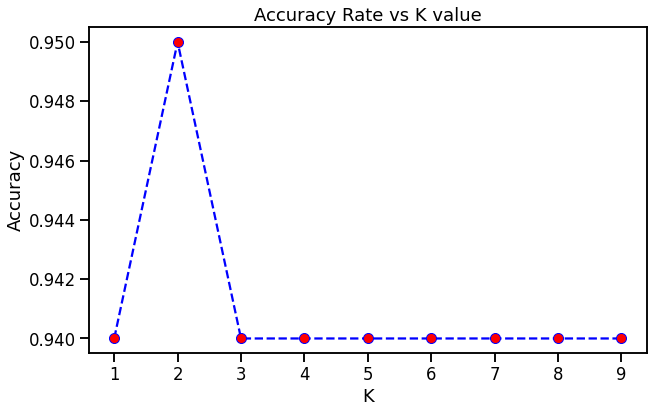

In [22]:
plt.figure(figsize=(10,6))
plt.plot(range(1,10),accuracy_rate,color='blue',linestyle='dashed',marker='o',markerfacecolor='red',markersize=10)
plt.title('Accuracy Rate vs K value')
plt.xlabel('K')
plt.ylabel('Accuracy')

As shown in the graph. K=2 gives us the best accuracy.

In [23]:
# Estimate KNN model and report outcomes
knn = KNeighborsClassifier(n_neighbors=2)
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1583
           2       0.97      0.87      0.92       863

    accuracy                           0.95      2446
   macro avg       0.95      0.93      0.94      2446
weighted avg       0.95      0.95      0.94      2446

Accuracy score:  0.95


> Plotting the confusion matrix for KNN

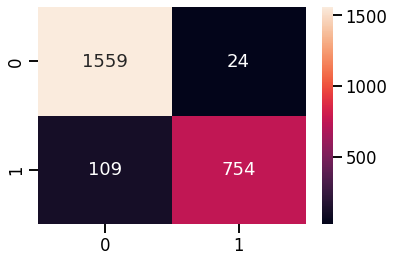

In [24]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

**Even though the accuracy for KNN (95%) is higher than that for Logistic Regression (93%), KNN model predicts a fair number of type 0s incorrectly.**

### XG BOOST

- Using a list of number of trees we will iterate through each and select the one that gives us the least error. 

In [ ]:
### BEGIN SOLUTION
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list = list()

# Iterate through various possibilities for number of trees
tree_list = [15, 25, 50, 100, 200, 400]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(n_estimators=n_trees, random_state=42)

    # Fit the model
    print(f'Fitting model with {n_trees} trees')
    GBC.fit(X_train.values, y_train.values)
    y_pred = GBC.predict(X_test)

    # Get the error
    error = 1.0 - accuracy_score(y_test, y_pred)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

- Plotting a graph to analyse the error rate for every number of trees.

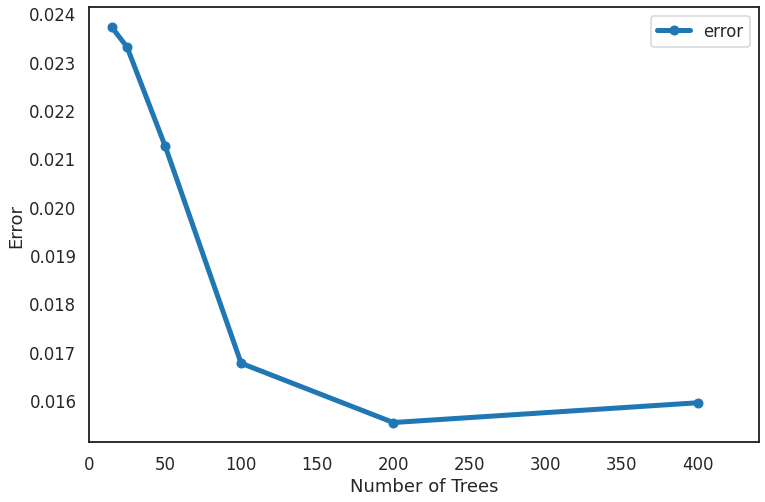

In [26]:
sns.set_context('talk')
sns.set_style('white')

# Create the plot
ax = error_df.plot(marker='o', figsize=(12, 8), linewidth=5)

# Set parameters
ax.set(xlabel='Number of Trees', ylabel='Error')
ax.set_xlim(0, max(error_df.index)*1.1);
### END SOLUTION

- As shown in the graph, no. of trees=200 gives us the least error

> We can also make the use of **GridSearchCV** library of Sklearn to find the best estimator.

In [27]:
### BEGIN SOLUTION
from sklearn.model_selection import GridSearchCV

# The parameters to be fit
param_grid = {'n_estimators': tree_list,
              'learning_rate': [0.1, 0.01, 0.001, 0.0001],
              'subsample': [1.0, 0.5],
              'max_features': [1, 2, 3, 4]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

In [28]:
GV_GBC.best_estimator_

GradientBoostingClassifier(max_features=4, n_estimators=200, random_state=42)

In [29]:
from sklearn.metrics import classification_report

y_pred = GV_GBC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1611
           2       0.96      0.99      0.97       835

    accuracy                           0.98      2446
   macro avg       0.98      0.98      0.98      2446
weighted avg       0.98      0.98      0.98      2446


**We can get an accuracy of 98% with XGBOOST, higher than the rest of the models.**

In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.982011447260834

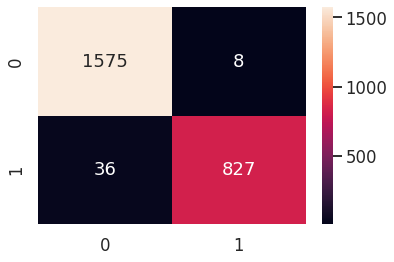

In [31]:
from sklearn.metrics import confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

> Confusion matrix shows least amount values predicted incorrectly.

## Conclusion: 
- Logistic Regression: 93% 
- KNN: 95%
- XGBOOST: 98% 

### Hence the best Algorithm for the prediction of the type of forest fire detected by MODIS satellite will be ***XGBOOST*** 

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).squeeze()  # Convert y_train to a 1D tensor
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).squeeze()  # Convert y_test to a 1D tensor

# Create a TensorDataset from the tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create a DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the model
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, len(y_train.iloc[:, 0].unique())),
)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training loop
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    for batch in train_loader:
        # Move the batch data to the device the model is on
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss for this epoch
    print(f'Epoch {epoch+1}/{n_epochs} - Loss: {loss.item()}')

# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_loader:
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Make predictions
        y_pred = model(X_batch)
        _, predicted = torch.max(y_pred.data, 1)

        # Count the number of correct predictions
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    print(f'Accuracy: {correct / total * 100}%')

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

# Scale the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Convert the labels to categorical
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# Define the model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(y_train.iloc[:, 0].unique()), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_categorical, epochs=10, batch_size=64)

# Evaluate the model
_, accuracy = model.evaluate(X_test, y_test_categorical)
print(f'Accuracy: {accuracy * 100}%')